In [74]:
# Import stuff
%load_ext autoreload
%autoreload 2

from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import time

import jpabringup as jpa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
@interact( vbias=(0, 5, 0.05) )

def tmp(vbias=0):
    jpa.setvolt(vbias)

interactive(children=(FloatSlider(value=0.0, description='vbias', max=5.0, step=0.05), Output()), _dom_classes…

In [75]:
# start VNA
jpa.start()

VNA identification: Keysight Technologies,P9374A,MY57212251,A.13.10.05



In [78]:
def dB( Sjk ):
    return 20 * np.log10( np.abs(Sjk) )

def plotSjk( farr, Sjk ):
    plt.plot( farr/1e9, dB(Sjk), 'darkred' )
    plt.grid( True )
    plt.xlabel( 'f [GHz]' )
    plt.ylabel( '$S_{11}$[dB]' )
    
def groupdelayFromS( freqarr, Sjk, windowSize=3 ):
    groupdelay = lambda x,y : np.abs(np.diff(x)/2/np.pi/y)
    boxcar     = lambda y,N : np.convolve(y, np.ones((N,))/N, mode='valid')
    
    df = np.mean( np.diff(freqarr) )
    phase = np.unwrap( np.angle(Sjk) )
    smoothphase = boxcar( phase, windowSize )
    tgd = groupdelay( smoothphase, df )
    
    lendiff = len(freqarr) - len(tgd)
    
    fgd = freqarr[:-lendiff] + df*lendiff/2
    
    return { 'fgd':fgd, 'tgd':tgd, 'phasegd':smoothphase }

VNA identification: Keysight Technologies,P9374A,MY57212251,A.13.10.05



In [79]:
fst = 3.5
fend = 8
npts = 801
df = round((fend-fst)/npts*1e4) / 1e4

prm = dict( fst=fst, fend=fend, df=df, pin=-43, IFBW=1e3, nave=1)

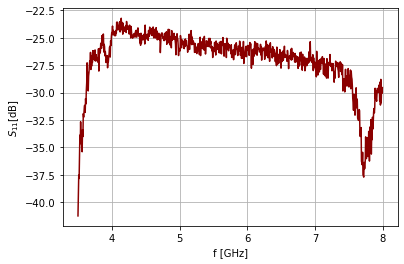

In [23]:
plotSjk( fvna, S21 )

VNA RF off
VNA disconnected


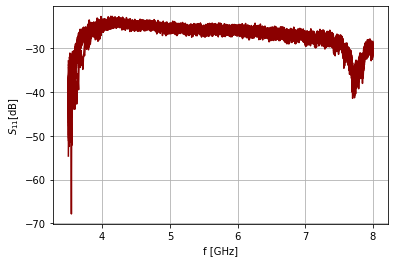

In [80]:
vbarr = np.linspace( 0, 4, 101 )
S11 = np.zeros( (len(vbarr), len(fvna)), dtype=complex )
S11dB = np.zeros( (len(vbarr), len(fvna)) )

for idx,vb in enumerate( vbarr ):
    jpa.setvolt(vb); time.sleep(0.1)
    fvna, S11[idx,:] = jpa.sweep( prm, verbose = False )
    S11dB[idx,:] = dB( S11[idx,:] )

    plotSjk(fvna,S11[idx,:])

# RF off
jpa.rf_off()
jpa.setvolt(0.0)

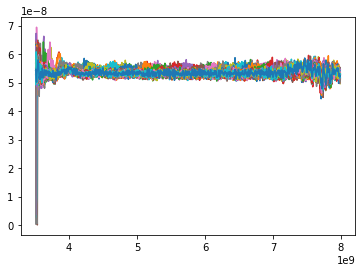

In [81]:
wsize = 3
tgdimg = np.zeros( (len(vbarr), len(fvna)-wsize) )

for idx, sjk in enumerate(S11):
    gd = groupdelayFromS( fvna, sjk, windowSize=wsize )
    fgd, tgdimg[idx,:] = gd['fgd'], gd['tgd']
    plt.plot( fgd,gd['tgd'] )

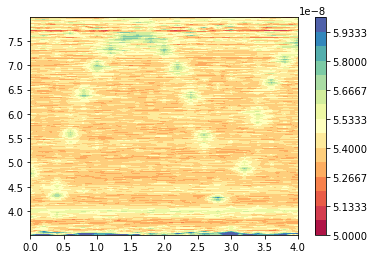

In [52]:
nlevels = 16
clim = [50e-9, 60e-9]
clevels = np.linspace( clim[0], clim[-1], nlevels )
plt.contourf( vbarr, fgd/1e9, tgdimg.T, clevels, cmap='Spectral' )
plt.colorbar()

<IPython.core.display.Javascript object>


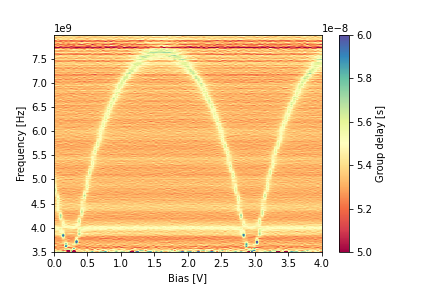

Text(0, 0.5, 'Frequency [Hz]')

In [84]:
%matplotlib notebook
x_min, x_max = np.min(vbarr), np.max(vbarr)
y_min, y_max = np.min(fvna), np.max(fvna)

plt.imshow(
    tgdimg.T,
    origin = "lower",
    aspect = "auto",
    extent = [x_min, x_max, y_min, y_max],
    vmin = 50e-9,
    vmax = 60e-9,
    cmap = "Spectral",
    interpolation = None,
    )
plt.colorbar( label="Group delay [s]" )
plt.xlabel( "Bias [V]" )
plt.ylabel( "Frequency [Hz]" )